# Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler

In [2]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import warnings # Ignore alert messages
warnings.filterwarnings('ignore')

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


In [6]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.integration import KerasPruningCallback


# Importing reduced dataset with engineered features

In [7]:
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned_feature_engineered.csv.zip") # Dataset from the notebook "feature engineering"
df

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_z,Lead_z_accel_right_side,Susp_travel_left,Susp_travel_right,Pitch_accel,...,Triaxial_x_RMA_55 samples,Triaxial_x_MA_55 samples,Triaxial_x_RMS_55 samples,Triaxial_z_mean_55 samples,Susp_travel_mean_55 samples,Susp_travel_skew_55 samples,Pitch_left_susp_mean_55 samples,Bounce_susp_mean_55 samples,Front_Roll_susp_skew_55 samples,Vert_irreg_right_rail
0,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000749,-0.001817,0.030900,-0.034100,-0.000459,...,0.008054,0.000065,0.000457,-0.000293,0.004538,-1.143003,0.000911,0.001606,0.941525,-0.0712
1,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000749,-0.001812,0.031600,-0.035600,-0.000542,...,0.008238,0.000068,0.000457,-0.000307,0.003883,-1.156428,0.000941,0.001485,0.893110,-0.0753
2,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000727,-0.001605,0.032000,-0.036700,-0.000613,...,0.008436,0.000071,0.000458,-0.000320,0.003208,-1.139831,0.000970,0.001362,0.843661,-0.0791
3,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000650,-0.000912,0.031400,-0.037000,-0.000654,...,0.008647,0.000075,0.000459,-0.000332,0.002527,-1.100159,0.000993,0.001242,0.787577,-0.0827
4,-0.037300,0.030900,0.025100,-0.0257,-0.000202,-0.000574,-0.000219,0.030900,-0.037300,-0.000695,...,0.008870,0.000079,0.000459,-0.000342,0.001840,-1.048016,0.001013,0.001125,0.728316,-0.0858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68096,-0.111903,-0.231038,0.133286,0.0503,0.001834,0.000079,0.004336,-0.231038,-0.111903,-0.003638,...,0.053665,0.002880,0.004202,-0.009225,-0.722654,-0.835219,-0.063069,-0.147773,-0.773285,0.0486
68097,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.000082,0.003567,-0.225703,-0.113222,-0.003363,...,0.053726,0.002887,0.004204,-0.008988,-0.693827,-0.847119,-0.063281,-0.143451,-0.788629,0.0511
68098,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.000321,0.002644,-0.220937,-0.114092,-0.003317,...,0.053553,0.002868,0.004196,-0.008838,-0.666117,-0.856692,-0.063529,-0.139384,-0.803025,0.0535
68099,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.000559,0.001721,-0.216170,-0.114961,-0.003272,...,0.053190,0.002829,0.004170,-0.008807,-0.639543,-0.864403,-0.063821,-0.135586,-0.816822,0.0558


# 1D convolutional neural network


Order matters in a convolutional time series, therefore, we will need to recreate the dataset and **not** shuffle it

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv1D, Reshape, Flatten, Conv1DTranspose, Concatenate, MaxPooling1D
from tensorflow.keras.optimizers import Adam

<img src='Images/1D_CNN.png' width="370" height="870">

Source: https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57

## Preprocessing

In [9]:
# Dataset from the notebook "feature engineering"
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned_feature_engineered.csv.zip")
y = pd.DataFrame(df['Vert_irreg_right_rail'])
X = df.drop(['Vert_irreg_right_rail'], axis=1)

In [10]:
X = X[1101:-1]
y = y.iloc[X.index]

In [11]:
X

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_z,Lead_z_accel_right_side,Susp_travel_left,Susp_travel_right,Pitch_accel,...,Triaxial_x_mean_55 samples,Triaxial_x_RMA_55 samples,Triaxial_x_MA_55 samples,Triaxial_x_RMS_55 samples,Triaxial_z_mean_55 samples,Susp_travel_mean_55 samples,Susp_travel_skew_55 samples,Pitch_left_susp_mean_55 samples,Bounce_susp_mean_55 samples,Front_Roll_susp_skew_55 samples
1101,-8.304548,6.066609,8.202814,-11.63059,-0.101963,-0.234380,-0.047818,8.202814,-11.630590,-0.103367,...,-0.006536,0.260015,0.067608,0.081388,0.034347,-8.304275,0.151238,0.916752,-1.812493,0.080548
1102,-8.271985,6.031888,8.338225,-11.59412,-0.058409,-0.531160,-0.171378,8.338225,-11.594120,0.062959,...,-0.006804,0.260610,0.067917,0.081556,0.027577,-8.365009,0.166222,0.901883,-1.826299,0.030264
1103,-8.206507,5.983220,8.432583,-11.45194,-0.033785,-0.763730,-0.308820,8.432583,-11.451940,0.135416,...,-0.006848,0.260733,0.067982,0.081574,0.015441,-8.420040,0.185252,0.884658,-1.836425,-0.019986
1104,-8.091293,5.914749,8.465488,-11.18242,-0.050202,-0.739720,-0.970220,8.465488,-11.182420,0.033702,...,-0.007313,0.261951,0.068619,0.081786,0.003165,-8.467317,0.208429,0.865144,-1.841909,-0.070774
1105,-7.911352,5.814396,8.504174,-10.83395,-0.082358,-0.601920,-0.380320,8.504174,-10.833950,-0.040861,...,-0.008435,0.264558,0.069991,0.082490,-0.006700,-8.505806,0.233240,0.843142,-1.842395,-0.122262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68095,-0.110475,-0.236510,0.126645,0.05850,0.001813,0.000221,0.005067,-0.236510,-0.110475,-0.003968,...,-0.000457,0.053260,0.002837,0.004196,-0.009502,-0.752566,-0.820666,-0.062879,-0.152327,-0.756720
68096,-0.111903,-0.231038,0.133286,0.05030,0.001834,0.000079,0.004336,-0.231038,-0.111903,-0.003638,...,-0.000432,0.053665,0.002880,0.004202,-0.009225,-0.722654,-0.835219,-0.063069,-0.147773,-0.773285
68097,-0.113222,-0.225703,0.140285,0.04220,0.001846,-0.000082,0.003567,-0.225703,-0.113222,-0.003363,...,-0.000427,0.053726,0.002887,0.004204,-0.008988,-0.693827,-0.847119,-0.063281,-0.143451,-0.788629
68098,-0.114092,-0.220937,0.148758,0.03470,0.001823,-0.000321,0.002644,-0.220937,-0.114092,-0.003317,...,-0.000443,0.053553,0.002868,0.004196,-0.008838,-0.666117,-0.856692,-0.063529,-0.139384,-0.803025


In [12]:
def reshape_dataset(X, y,n=50):

    # [n_sampes,n_time_steps,input_dimension]
    shape_x = (-1, n, X.shape[1])
    shape_y = (-1, n, y.shape[1])

    X_reshaped = tf.reshape(X, shape=shape_x)
    y_reshaped = tf.reshape(y, shape=shape_y)
    return X_reshaped, y_reshaped

<img src="https://github.com/kmkarakaya/ML_tutorials/blob/master/images/conv1d.gif?raw=true" width="500">

In [13]:
def create_scaled_dataset(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.15,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_scaled_dataset(X, y)

In [14]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    ax.plot(model.history['loss'], label='Train Loss')
    ax.plot(model.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()

In [15]:
def create_scaled_dataset_reshaped(X,y,window_size=100):

    X_train, X_test, y_train, y_test = create_scaled_dataset(X, y)

    X_train_reshaped, y_train_reshaped = reshape_dataset(X_train, y_train, n=window_size)
    X_test_reshaped, y_test_reshaped = reshape_dataset(X_test, y_test, n=window_size)

    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

X_train_re,y_train_re,X_test_re,y_test_re = create_scaled_dataset_reshaped(X,y)

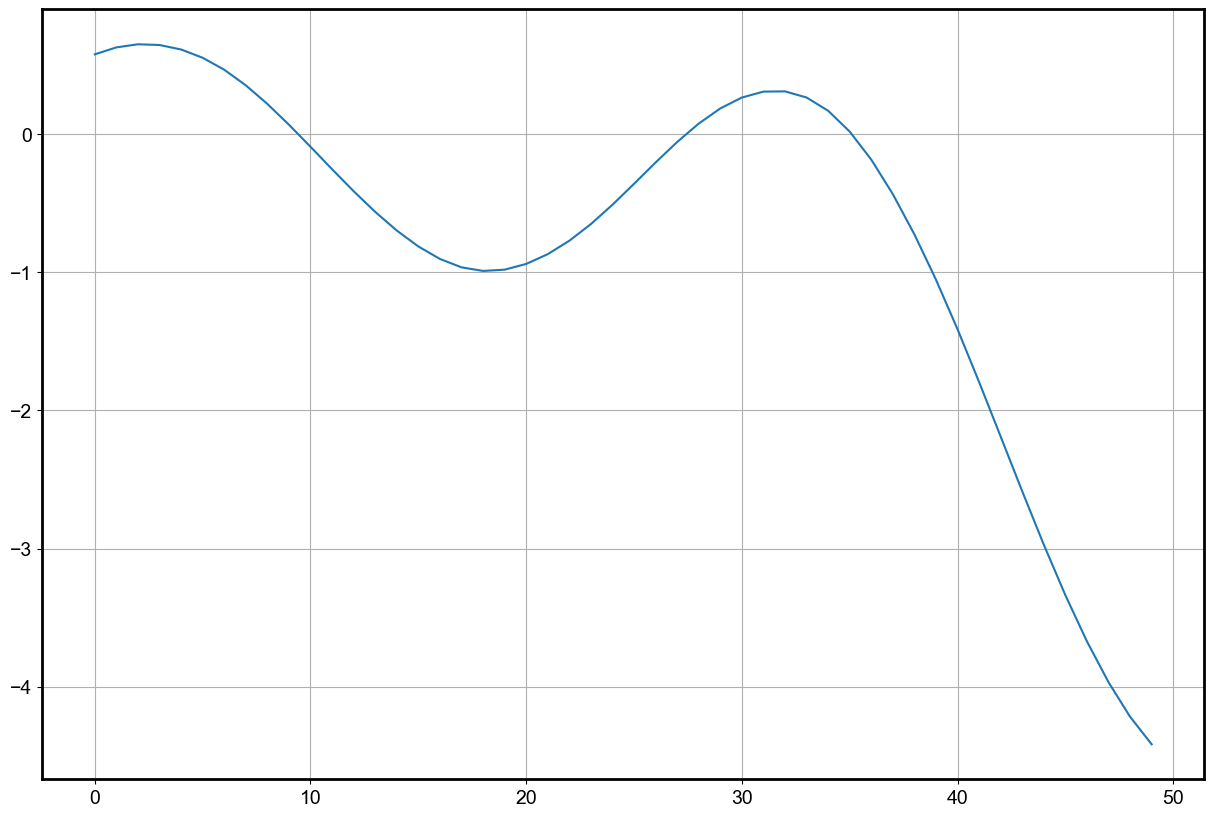

In [ ]:
plt.plot(y_train_re[0])

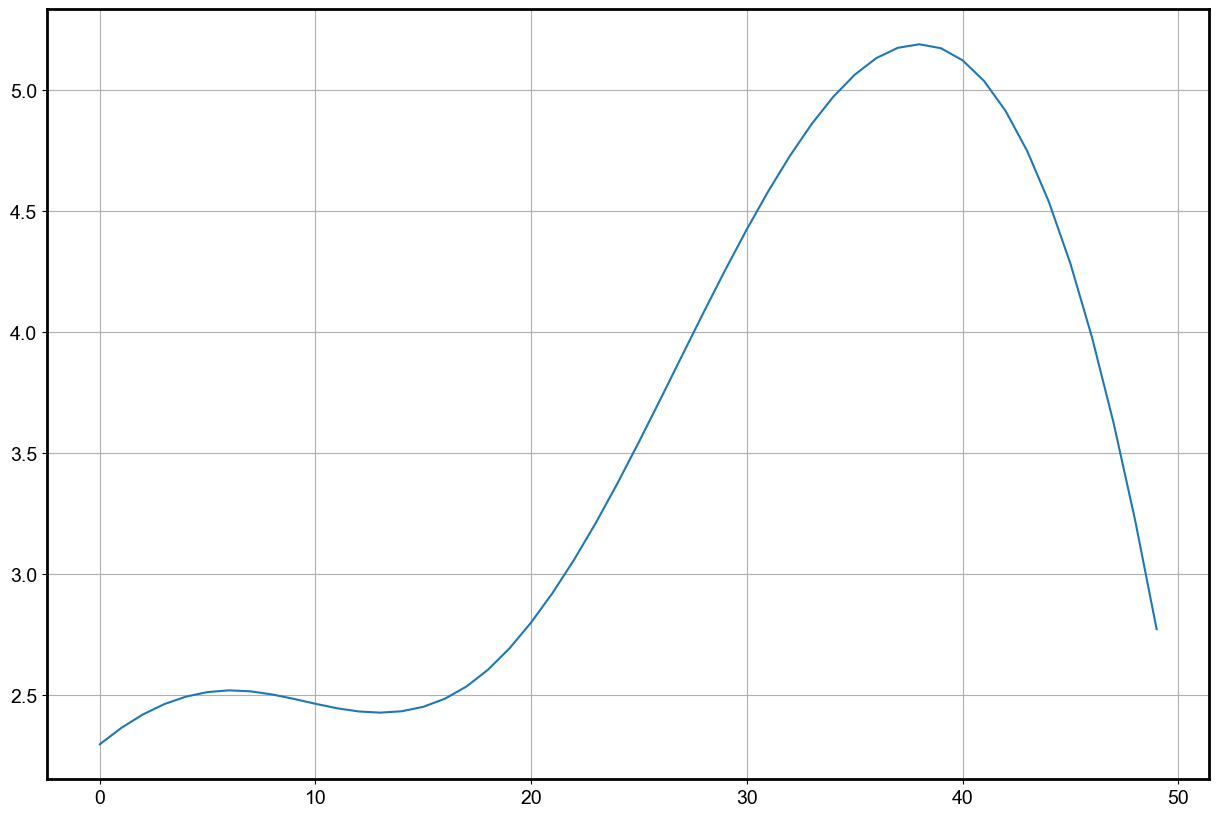

In [ ]:
plt.plot(y_train_re[20])

## Optuna

In [ ]:
class optuna_1D_conv_NN:
    
    def __init__(self,X,y):

        self.X = X
        self.y = y

        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None


        self.best_model = None
        self._model = None
    
        
        self.callbacks = None
        self.history = None
        self._history = None
        
        self.batchsize = X_train.shape[0]

    def objective(self,trial):
        
        MAX_EPOCHS = 500
        PATIENCE = 20  # Number of epochs to check if the error continues to decrease
        INTERVAL = 150  # Intermediate results saved and pruned/removed if it is bad
        
        window_size = trial.suggest_categorical('window_size', [20,40,50,100,125,200])
        self.X_train, self.y_train, self.X_test, self.y_test = create_scaled_dataset_reshaped(self.X, self.y, window_size=window_size)

        tf.keras.backend.clear_session()

        # 1. Convolutional part of the model

        num_layers_conv = trial.suggest_int('n_layers_conv', 1, 2)
        activation_conv = trial.suggest_categorical('activ_fun_conv', ['tanh', 'relu']) #'tanh'

        # 2. Initializing the model
        model = tf.keras.Sequential()
        input_layer = model.add(InputLayer(input_shape=(self.X_train.shape[1:]), name='input_layer'))

        for i in range(num_layers_conv):

            filters = trial.suggest_int('filters_layer{}'.format(i), 50, 400, step=10)
            kernel_size = trial.suggest_int('kernel_size'.format(i), 4, 30, step=2),
            strides = 1#trial.suggest_categorical('strides'.format(i), [1,2,4]),

            model.add(Conv1D(filters=filters, kernel_size=kernel_size,strides=strides, padding='same', activation=activation_conv))
            model.add(Dropout(0.5))


        model.add(MaxPooling1D(pool_size=2,name='MaxPooling1D'))
        model.add(Flatten())

        # 3. Add the vanilla neural network part

        num_layers_nn = trial.suggest_int('n_layers_nn', 1, 2)
        activation_nn = trial.suggest_categorical('activ_fun_nn', ['tanh','linear']) # relu isnt good
        
        for i in range(num_layers_nn):
            num_neurons = trial.suggest_int('n_units_l{}'.format(i), 800, 1400,step=20)
            model.add(tf.keras.layers.Dense(num_neurons, activation=activation_nn))
            model.add(Dropout(0.5))
            model.add(tf.keras.layers.BatchNormalization())
            
        model.add(Dropout(0.5))
        model.add(tf.keras.layers.Dense(self.y_train.shape[1], activation='linear'))

        # 4. Defining callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=PATIENCE,
                                                      mode='min')
    
        optuna_pruner = KerasPruningCallback(trial, "val_loss", interval=INTERVAL)
        self.callbacks = [early_stopping,optuna_pruner]
        
        # 5. Compile and fit the model
        learning_rate = 6e-4 #trial.suggest_loguniform("lr", 1e-5, 1e-3) #6e-4
        model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
        
        self._history = model.fit(self.X_train,
              self.y_train,
              epochs=MAX_EPOCHS,
              validation_split=0.15,
              #validation_data=(self.X_test, self.y_test),
              callbacks=self.callbacks,
              #batch_size=self.batchsize,
              shuffle=True,
              verbose=0)   
        
        self._model = model
        
        MSE_score_test_set = model.evaluate(self.X_test, self.y_test, verbose=0)
        return MSE_score_test_set 
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
            self.history = self._history
            
conv_1D_NN = optuna_1D_conv_NN(X,y)

In [ ]:
study2 = optuna.create_study(direction='minimize',
                            # Fix a seed to have reproducible results
                            sampler=optuna.samplers.TPESampler(seed=10),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name='1D_CNN')

[I 2021-08-09 12:20:18,772] A new study created in memory with name: 1D_CNN


In [ ]:
study2.optimize(conv_1D_NN.objective,
               n_trials=100,
               callbacks=[conv_1D_NN.callback],
               show_progress_bar=True)

  1%|          | 1/100 [01:33<2:34:00, 93.34s/it]

[I 2021-08-09 12:21:52,141] Trial 0 finished with value: 10.533598899841309 and parameters: {'window_size': 20, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 80, 'kernel_size': 22, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1300, 'n_units_l1': 1160}. Best is trial 0 with value: 10.533598899841309.


  2%|▏         | 2/100 [02:40<2:06:53, 77.69s/it]

[I 2021-08-09 12:22:58,871] Trial 1 finished with value: 8.51867961883545 and parameters: {'window_size': 50, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 20, 'n_layers_nn': 2, 'activ_fun_nn': 'tanh', 'n_units_l0': 1280, 'n_units_l1': 1120}. Best is trial 1 with value: 8.51867961883545.


  3%|▎         | 3/100 [05:44<3:24:15, 126.35s/it]

[I 2021-08-09 12:26:03,122] Trial 2 finished with value: 7.207314968109131 and parameters: {'window_size': 20, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 340, 'kernel_size': 8, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 980, 'n_units_l1': 1340}. Best is trial 2 with value: 7.207314968109131.


  4%|▍         | 4/100 [05:57<2:10:21, 81.47s/it] 

[I 2021-08-09 12:26:15,803] Trial 3 finished with value: 10.707791328430176 and parameters: {'window_size': 125, 'n_layers_conv': 1, 'activ_fun_conv': 'relu', 'filters_layer0': 210, 'kernel_size': 26, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1120}. Best is trial 2 with value: 7.207314968109131.


  5%|▌         | 5/100 [06:28<1:40:18, 63.35s/it]

[I 2021-08-09 12:26:47,027] Trial 4 finished with value: 21.345869064331055 and parameters: {'window_size': 20, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 160, 'kernel_size': 20, 'filters_layer1': 170, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 1340}. Best is trial 2 with value: 7.207314968109131.


  6%|▌         | 6/100 [08:15<2:02:54, 78.45s/it]

[I 2021-08-09 12:28:34,787] Trial 5 finished with value: 8.423057556152344 and parameters: {'window_size': 40, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 250, 'kernel_size': 18, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 1400}. Best is trial 2 with value: 7.207314968109131.


  7%|▋         | 7/100 [10:06<2:18:03, 89.07s/it]

[I 2021-08-09 12:30:25,706] Trial 6 finished with value: 6.0644731521606445 and parameters: {'window_size': 50, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 210, 'kernel_size': 24, 'filters_layer1': 300, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1140, 'n_units_l1': 980}. Best is trial 6 with value: 6.0644731521606445.


  8%|▊         | 8/100 [10:49<1:53:48, 74.22s/it]

[I 2021-08-09 12:31:08,132] Trial 7 finished with value: 9.395883560180664 and parameters: {'window_size': 40, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 120, 'kernel_size': 24, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 1160}. Best is trial 6 with value: 6.0644731521606445.


  9%|▉         | 9/100 [11:21<1:32:37, 61.07s/it]

[I 2021-08-09 12:31:40,283] Trial 8 finished with value: 9.437965393066406 and parameters: {'window_size': 50, 'n_layers_conv': 1, 'activ_fun_conv': 'relu', 'filters_layer0': 380, 'kernel_size': 18, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1140, 'n_units_l1': 1280}. Best is trial 6 with value: 6.0644731521606445.


 10%|█         | 10/100 [11:48<1:15:58, 50.65s/it]

[I 2021-08-09 12:32:07,623] Trial 9 finished with value: 28.09636688232422 and parameters: {'window_size': 40, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 100, 'kernel_size': 18, 'filters_layer1': 340, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 1160}. Best is trial 6 with value: 6.0644731521606445.


 11%|█         | 11/100 [14:23<2:02:19, 82.47s/it]

[I 2021-08-09 12:34:42,227] Trial 10 finished with value: 4.89009428024292 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 300, 'kernel_size': 30, 'filters_layer1': 370, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 880, 'n_units_l1': 800}. Best is trial 10 with value: 4.89009428024292.


 12%|█▏        | 12/100 [16:57<2:32:49, 104.20s/it]

[I 2021-08-09 12:37:16,132] Trial 11 finished with value: 5.7276458740234375 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 290, 'kernel_size': 30, 'filters_layer1': 380, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 800, 'n_units_l1': 820}. Best is trial 10 with value: 4.89009428024292.


 13%|█▎        | 13/100 [19:28<2:51:50, 118.51s/it]

[I 2021-08-09 12:39:47,581] Trial 12 finished with value: 5.613309860229492 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 300, 'kernel_size': 30, 'filters_layer1': 400, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 800, 'n_units_l1': 840}. Best is trial 10 with value: 4.89009428024292.


 14%|█▍        | 14/100 [21:33<2:52:23, 120.28s/it]

[I 2021-08-09 12:41:51,937] Trial 13 finished with value: 5.804355144500732 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 310, 'kernel_size': 30, 'filters_layer1': 400, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 800, 'n_units_l1': 800}. Best is trial 10 with value: 4.89009428024292.


 15%|█▌        | 15/100 [22:03<2:12:03, 93.21s/it] 

[I 2021-08-09 12:42:22,425] Trial 14 finished with value: 5.4933271408081055 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 380, 'kernel_size': 8, 'filters_layer1': 60, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 900, 'n_units_l1': 940}. Best is trial 10 with value: 4.89009428024292.


 16%|█▌        | 16/100 [22:32<1:43:28, 73.92s/it]

[I 2021-08-09 12:42:51,527] Trial 15 finished with value: 5.457927227020264 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 400, 'kernel_size': 10, 'filters_layer1': 50, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 920, 'n_units_l1': 960}. Best is trial 10 with value: 4.89009428024292.


 17%|█▋        | 17/100 [23:18<1:30:37, 65.51s/it]

[I 2021-08-09 12:43:37,485] Trial 16 finished with value: 5.436042308807373 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 400, 'kernel_size': 12, 'filters_layer1': 60, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 960, 'n_units_l1': 980}. Best is trial 10 with value: 4.89009428024292.


 18%|█▊        | 18/100 [23:49<1:15:13, 55.04s/it]

[I 2021-08-09 12:44:08,149] Trial 17 finished with value: 5.484175682067871 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 340, 'kernel_size': 12, 'filters_layer1': 170, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1020, 'n_units_l1': 1040}. Best is trial 10 with value: 4.89009428024292.


 19%|█▉        | 19/100 [24:27<1:07:27, 49.97s/it]

[I 2021-08-09 12:44:46,313] Trial 18 finished with value: 6.409364700317383 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 260, 'kernel_size': 14, 'filters_layer1': 260, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 880, 'n_units_l1': 900}. Best is trial 10 with value: 4.89009428024292.


 20%|██        | 20/100 [25:22<1:08:32, 51.41s/it]

[I 2021-08-09 12:45:41,068] Trial 19 finished with value: 5.016526699066162 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 350, 'kernel_size': 14, 'filters_layer1': 130, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1000, 'n_units_l1': 1200}. Best is trial 10 with value: 4.89009428024292.


 21%|██        | 21/100 [26:05<1:04:38, 49.10s/it]

[I 2021-08-09 12:46:24,784] Trial 20 finished with value: 8.82201862335205 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 360, 'kernel_size': 4, 'filters_layer1': 140, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1040, 'n_units_l1': 1280}. Best is trial 10 with value: 4.89009428024292.


 22%|██▏       | 22/100 [26:37<56:46, 43.68s/it]  

[I 2021-08-09 12:46:55,820] Trial 21 finished with value: 4.9307146072387695 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 320, 'kernel_size': 14, 'filters_layer1': 100, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 980, 'n_units_l1': 1180}. Best is trial 10 with value: 4.89009428024292.


 23%|██▎       | 23/100 [27:33<1:00:48, 47.38s/it]

[I 2021-08-09 12:47:51,831] Trial 22 finished with value: 4.841860294342041 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 320, 'kernel_size': 16, 'filters_layer1': 150, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 860, 'n_units_l1': 1200}. Best is trial 22 with value: 4.841860294342041.


 24%|██▍       | 24/100 [28:02<53:16, 42.06s/it]  

[I 2021-08-09 12:48:21,472] Trial 23 finished with value: 5.2688751220703125 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 270, 'kernel_size': 14, 'filters_layer1': 100, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 860, 'n_units_l1': 1240}. Best is trial 22 with value: 4.841860294342041.


 25%|██▌       | 25/100 [29:24<1:07:30, 54.01s/it]

[I 2021-08-09 12:49:43,356] Trial 24 finished with value: 4.964679718017578 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 330, 'kernel_size': 16, 'filters_layer1': 220, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 840, 'n_units_l1': 1080}. Best is trial 22 with value: 4.841860294342041.


 26%|██▌       | 26/100 [30:12<1:04:31, 52.32s/it]

[I 2021-08-09 12:50:31,753] Trial 25 finished with value: 5.5423736572265625 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 240, 'kernel_size': 16, 'filters_layer1': 210, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1060, 'n_units_l1': 1180}. Best is trial 22 with value: 4.841860294342041.


 27%|██▋       | 27/100 [30:37<53:30, 43.98s/it]  

[I 2021-08-09 12:50:56,255] Trial 26 finished with value: 5.175092697143555 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 290, 'kernel_size': 4, 'filters_layer1': 110, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 920, 'n_units_l1': 1380}. Best is trial 22 with value: 4.841860294342041.


 28%|██▊       | 28/100 [31:26<54:39, 45.54s/it]

[I 2021-08-09 12:51:45,449] Trial 27 finished with value: 4.935132026672363 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 320, 'kernel_size': 8, 'filters_layer1': 170, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 960, 'n_units_l1': 1120}. Best is trial 22 with value: 4.841860294342041.


 29%|██▉       | 29/100 [32:45<1:05:41, 55.51s/it]

[I 2021-08-09 12:53:04,224] Trial 28 finished with value: 5.745443820953369 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 280, 'kernel_size': 12, 'filters_layer1': 100, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 840, 'n_units_l1': 1060}. Best is trial 22 with value: 4.841860294342041.


 30%|███       | 30/100 [33:47<1:06:57, 57.39s/it]

[I 2021-08-09 12:54:05,987] Trial 29 finished with value: 5.941376686096191 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 380, 'kernel_size': 22, 'filters_layer1': 260, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1060, 'n_units_l1': 1240}. Best is trial 22 with value: 4.841860294342041.


 31%|███       | 31/100 [36:39<1:45:30, 91.75s/it]

[I 2021-08-09 12:56:57,916] Trial 30 finished with value: 8.9422025680542 and parameters: {'window_size': 20, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 50, 'kernel_size': 28, 'filters_layer1': 80, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 940}. Best is trial 22 with value: 4.841860294342041.


 32%|███▏      | 32/100 [37:20<1:26:54, 76.69s/it]

[I 2021-08-09 12:57:39,465] Trial 31 finished with value: 5.230177402496338 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 310, 'kernel_size': 6, 'filters_layer1': 170, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 960, 'n_units_l1': 1120}. Best is trial 22 with value: 4.841860294342041.


 33%|███▎      | 33/100 [38:17<1:18:57, 70.70s/it]

[I 2021-08-09 12:58:36,195] Trial 32 finished with value: 4.860485553741455 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 330, 'kernel_size': 10, 'filters_layer1': 140, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 880, 'n_units_l1': 1160}. Best is trial 22 with value: 4.841860294342041.


 34%|███▍      | 34/100 [39:10<1:11:57, 65.41s/it]

[I 2021-08-09 12:59:29,256] Trial 33 finished with value: 5.331874370574951 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 370, 'kernel_size': 10, 'filters_layer1': 140, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 880, 'n_units_l1': 1220}. Best is trial 22 with value: 4.841860294342041.


 35%|███▌      | 35/100 [40:29<1:15:19, 69.54s/it]

[I 2021-08-09 13:00:48,425] Trial 34 finished with value: 5.294214725494385 and parameters: {'window_size': 200, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 330, 'kernel_size': 20, 'filters_layer1': 190, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 840, 'n_units_l1': 1160}. Best is trial 22 with value: 4.841860294342041.


 36%|███▌      | 36/100 [41:32<1:12:02, 67.54s/it]

[I 2021-08-09 13:01:51,314] Trial 35 finished with value: 6.59030294418335 and parameters: {'window_size': 50, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 230, 'kernel_size': 16, 'filters_layer1': 130, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 900, 'n_units_l1': 1260}. Best is trial 22 with value: 4.841860294342041.


 37%|███▋      | 37/100 [43:53<1:34:07, 89.65s/it]

[I 2021-08-09 13:04:12,538] Trial 36 finished with value: 11.128154754638672 and parameters: {'window_size': 20, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 350, 'kernel_size': 10, 'filters_layer1': 250, 'n_layers_nn': 2, 'activ_fun_nn': 'tanh', 'n_units_l0': 1000, 'n_units_l1': 1160}. Best is trial 22 with value: 4.841860294342041.


 38%|███▊      | 38/100 [44:15<1:11:31, 69.22s/it]

[I 2021-08-09 13:04:34,103] Trial 37 finished with value: 7.956380367279053 and parameters: {'window_size': 200, 'n_layers_conv': 1, 'activ_fun_conv': 'relu', 'filters_layer0': 190, 'kernel_size': 14, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 1240, 'n_units_l1': 1340}. Best is trial 22 with value: 4.841860294342041.


 39%|███▉      | 39/100 [44:35<55:32, 54.63s/it]  

[I 2021-08-09 13:04:54,691] Trial 38 finished with value: 9.503527641296387 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 270, 'kernel_size': 6, 'filters_layer1': 80, 'n_layers_nn': 2, 'activ_fun_nn': 'tanh', 'n_units_l0': 820, 'n_units_l1': 1040}. Best is trial 22 with value: 4.841860294342041.


 40%|████      | 40/100 [46:06<1:05:33, 65.56s/it]

[I 2021-08-09 13:06:25,763] Trial 39 finished with value: 7.283651828765869 and parameters: {'window_size': 40, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 310, 'kernel_size': 22, 'n_layers_nn': 2, 'activ_fun_nn': 'linear', 'n_units_l0': 880, 'n_units_l1': 1140}. Best is trial 22 with value: 4.841860294342041.


 41%|████      | 41/100 [46:47<57:08, 58.10s/it]  

[I 2021-08-09 13:07:06,453] Trial 40 finished with value: 4.929043292999268 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 250, 'kernel_size': 20, 'filters_layer1': 150, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1100}. Best is trial 22 with value: 4.841860294342041.


 42%|████▏     | 42/100 [47:50<57:32, 59.53s/it]

[I 2021-08-09 13:08:09,328] Trial 41 finished with value: 5.008270740509033 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 250, 'kernel_size': 20, 'filters_layer1': 150, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1220}. Best is trial 22 with value: 4.841860294342041.


 43%|████▎     | 43/100 [49:08<1:01:43, 64.97s/it]

[I 2021-08-09 13:09:26,974] Trial 42 finished with value: 5.040370464324951 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 290, 'kernel_size': 26, 'filters_layer1': 120, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1080}. Best is trial 22 with value: 4.841860294342041.


 44%|████▍     | 44/100 [50:03<57:52, 62.01s/it]  

[I 2021-08-09 13:10:22,084] Trial 43 finished with value: 5.076727390289307 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 210, 'kernel_size': 18, 'filters_layer1': 190, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1100}. Best is trial 22 with value: 4.841860294342041.


 45%|████▌     | 45/100 [51:46<1:08:09, 74.35s/it]

[I 2021-08-09 13:12:05,212] Trial 44 finished with value: 4.571178913116455 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 330, 'kernel_size': 12, 'filters_layer1': 300, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1000}. Best is trial 44 with value: 4.571178913116455.


 46%|████▌     | 46/100 [52:09<53:01, 58.92s/it]  

[I 2021-08-09 13:12:28,124] Trial 45 finished with value: 30.12017822265625 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 180, 'kernel_size': 12, 'filters_layer1': 330, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 1120}. Best is trial 44 with value: 4.571178913116455.


 47%|████▋     | 47/100 [52:58<49:27, 56.00s/it]

[I 2021-08-09 13:13:17,307] Trial 46 finished with value: 4.947721004486084 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 340, 'kernel_size': 8, 'filters_layer1': 360, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1180}. Best is trial 44 with value: 4.571178913116455.


 48%|████▊     | 48/100 [53:51<47:51, 55.23s/it]

[I 2021-08-09 13:14:10,738] Trial 47 finished with value: 5.325875282287598 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 300, 'kernel_size': 10, 'filters_layer1': 330, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 920}. Best is trial 44 with value: 4.571178913116455.


 49%|████▉     | 49/100 [56:16<1:09:45, 82.07s/it]

[I 2021-08-09 13:16:35,446] Trial 48 finished with value: 6.029663562774658 and parameters: {'window_size': 50, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 270, 'kernel_size': 22, 'filters_layer1': 300, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 800}. Best is trial 44 with value: 4.571178913116455.


 50%|█████     | 50/100 [57:41<1:08:59, 82.78s/it]

[I 2021-08-09 13:17:59,895] Trial 49 finished with value: 4.8014817237854 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 360, 'kernel_size': 16, 'filters_layer1': 290, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1320}. Best is trial 44 with value: 4.571178913116455.


 51%|█████     | 51/100 [58:47<1:03:35, 77.86s/it]

[I 2021-08-09 13:19:06,276] Trial 50 finished with value: 6.57816219329834 and parameters: {'window_size': 40, 'n_layers_conv': 1, 'activ_fun_conv': 'tanh', 'filters_layer0': 400, 'kernel_size': 16, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1280}. Best is trial 44 with value: 4.571178913116455.


 52%|█████▏    | 52/100 [59:54<59:40, 74.59s/it]  

[I 2021-08-09 13:20:13,223] Trial 51 finished with value: 6.368466854095459 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 360, 'kernel_size': 18, 'filters_layer1': 300, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 44 with value: 4.571178913116455.


 53%|█████▎    | 53/100 [1:01:08<58:14, 74.34s/it]

[I 2021-08-09 13:21:26,991] Trial 52 finished with value: 5.979743957519531 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 330, 'kernel_size': 24, 'filters_layer1': 290, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 44 with value: 4.571178913116455.


 54%|█████▍    | 54/100 [1:02:04<52:51, 68.94s/it]

[I 2021-08-09 13:22:23,332] Trial 53 finished with value: 5.1991071701049805 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 380, 'kernel_size': 12, 'filters_layer1': 380, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1380}. Best is trial 44 with value: 4.571178913116455.


 55%|█████▌    | 55/100 [1:03:43<58:24, 77.87s/it]

[I 2021-08-09 13:24:02,029] Trial 54 finished with value: 5.126039505004883 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 350, 'kernel_size': 18, 'filters_layer1': 280, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 860}. Best is trial 44 with value: 4.571178913116455.


 56%|█████▌    | 56/100 [1:05:04<57:47, 78.80s/it]

[I 2021-08-09 13:25:23,002] Trial 55 finished with value: 6.030814170837402 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 300, 'kernel_size': 14, 'filters_layer1': 350, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1020}. Best is trial 44 with value: 4.571178913116455.


 57%|█████▋    | 57/100 [1:06:34<58:53, 82.17s/it]

[I 2021-08-09 13:26:53,038] Trial 56 finished with value: 10.988458633422852 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 320, 'kernel_size': 28, 'filters_layer1': 320, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1200}. Best is trial 44 with value: 4.571178913116455.


 58%|█████▊    | 58/100 [1:12:11<1:51:05, 158.69s/it]

[I 2021-08-09 13:32:30,286] Trial 57 pruned. Trial was pruned at epoch 149.


 59%|█████▉    | 59/100 [1:13:17<1:29:27, 130.91s/it]

[I 2021-08-09 13:33:36,353] Trial 58 finished with value: 7.896420955657959 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 250, 'kernel_size': 16, 'filters_layer1': 230, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 940}. Best is trial 44 with value: 4.571178913116455.


 60%|██████    | 60/100 [1:14:40<1:17:38, 116.45s/it]

[I 2021-08-09 13:34:59,088] Trial 59 finished with value: 4.768497467041016 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 280, 'kernel_size': 12, 'filters_layer1': 400, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1280}. Best is trial 44 with value: 4.571178913116455.


 61%|██████    | 61/100 [1:17:18<1:23:46, 128.88s/it]

[I 2021-08-09 13:37:36,960] Trial 60 finished with value: 5.495108127593994 and parameters: {'window_size': 50, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 310, 'kernel_size': 12, 'filters_layer1': 400, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1280}. Best is trial 44 with value: 4.571178913116455.


 62%|██████▏   | 62/100 [1:18:20<1:09:03, 109.03s/it]

[I 2021-08-09 13:38:39,672] Trial 61 finished with value: 5.800466060638428 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 290, 'kernel_size': 14, 'filters_layer1': 360, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1300}. Best is trial 44 with value: 4.571178913116455.


 63%|██████▎   | 63/100 [1:18:56<53:35, 86.92s/it]   

[I 2021-08-09 13:39:14,988] Trial 62 finished with value: 4.69155740737915 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 230, 'kernel_size': 10, 'filters_layer1': 160, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1320}. Best is trial 44 with value: 4.571178913116455.


 64%|██████▍   | 64/100 [1:19:58<47:40, 79.45s/it]

[I 2021-08-09 13:40:17,033] Trial 63 finished with value: 4.676884174346924 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 280, 'kernel_size': 10, 'filters_layer1': 190, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1320}. Best is trial 44 with value: 4.571178913116455.


 65%|██████▌   | 65/100 [1:20:48<41:17, 70.79s/it]

[I 2021-08-09 13:41:07,596] Trial 64 finished with value: 4.980592250823975 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 130, 'kernel_size': 8, 'filters_layer1': 190, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1320}. Best is trial 44 with value: 4.571178913116455.


 66%|██████▌   | 66/100 [1:21:58<39:58, 70.53s/it]

[I 2021-08-09 13:42:17,527] Trial 65 finished with value: 4.6306633949279785 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 280, 'kernel_size': 10, 'filters_layer1': 160, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1400}. Best is trial 44 with value: 4.571178913116455.


 67%|██████▋   | 67/100 [1:22:50<35:40, 64.88s/it]

[I 2021-08-09 13:43:09,206] Trial 66 finished with value: 4.624908447265625 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 230, 'kernel_size': 6, 'filters_layer1': 160, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1380}. Best is trial 44 with value: 4.571178913116455.


 68%|██████▊   | 68/100 [1:23:32<30:59, 58.12s/it]

[I 2021-08-09 13:43:51,574] Trial 67 finished with value: 5.02395486831665 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 230, 'kernel_size': 6, 'filters_layer1': 210, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1400}. Best is trial 44 with value: 4.571178913116455.


 69%|██████▉   | 69/100 [1:24:21<28:35, 55.35s/it]

[I 2021-08-09 13:44:40,446] Trial 68 finished with value: 4.948093891143799 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 10, 'filters_layer1': 170, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1380}. Best is trial 44 with value: 4.571178913116455.


 70%|███████   | 70/100 [1:25:09<26:36, 53.22s/it]

[I 2021-08-09 13:45:28,691] Trial 69 finished with value: 5.133273601531982 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 160, 'kernel_size': 6, 'filters_layer1': 180, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 44 with value: 4.571178913116455.


 71%|███████   | 71/100 [1:26:12<27:07, 56.13s/it]

[I 2021-08-09 13:46:31,626] Trial 70 finished with value: 4.880003929138184 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 280, 'kernel_size': 8, 'filters_layer1': 160, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1260}. Best is trial 44 with value: 4.571178913116455.


 72%|███████▏  | 72/100 [1:26:44<22:48, 48.86s/it]

[I 2021-08-09 13:47:03,520] Trial 71 finished with value: 5.325263977050781 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 260, 'kernel_size': 12, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1320}. Best is trial 44 with value: 4.571178913116455.


 73%|███████▎  | 73/100 [1:27:20<20:13, 44.96s/it]

[I 2021-08-09 13:47:39,368] Trial 72 finished with value: 5.400664806365967 and parameters: {'window_size': 100, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 240, 'kernel_size': 10, 'filters_layer1': 160, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1380}. Best is trial 44 with value: 4.571178913116455.


 74%|███████▍  | 74/100 [1:28:09<19:56, 46.03s/it]

[I 2021-08-09 13:48:27,900] Trial 73 finished with value: 4.436824321746826 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 12, 'filters_layer1': 230, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 73 with value: 4.436824321746826.


 75%|███████▌  | 75/100 [1:29:06<20:37, 49.48s/it]

[I 2021-08-09 13:49:25,443] Trial 74 finished with value: 4.8216633796691895 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 12, 'filters_layer1': 250, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 73 with value: 4.436824321746826.


 76%|███████▌  | 76/100 [1:30:01<20:25, 51.07s/it]

[I 2021-08-09 13:50:20,231] Trial 75 finished with value: 4.401090145111084 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 10, 'filters_layer1': 230, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1300}. Best is trial 75 with value: 4.401090145111084.


 77%|███████▋  | 77/100 [1:31:07<21:17, 55.55s/it]

[I 2021-08-09 13:51:26,211] Trial 76 finished with value: 4.77223539352417 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 170, 'kernel_size': 10, 'filters_layer1': 230, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1300}. Best is trial 75 with value: 4.401090145111084.


 78%|███████▊  | 78/100 [1:32:09<21:03, 57.45s/it]

[I 2021-08-09 13:52:28,106] Trial 77 finished with value: 4.526377201080322 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 210, 'kernel_size': 4, 'filters_layer1': 220, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 75 with value: 4.401090145111084.


 79%|███████▉  | 79/100 [1:32:32<16:33, 47.31s/it]

[I 2021-08-09 13:52:51,743] Trial 78 finished with value: 10.959939002990723 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 220, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1400}. Best is trial 75 with value: 4.401090145111084.


 80%|████████  | 80/100 [1:33:23<16:06, 48.34s/it]

[I 2021-08-09 13:53:42,503] Trial 79 finished with value: 4.8563666343688965 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 6, 'filters_layer1': 240, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 75 with value: 4.401090145111084.


 81%|████████  | 81/100 [1:34:08<14:55, 47.13s/it]

[I 2021-08-09 13:54:26,813] Trial 80 finished with value: 5.374202251434326 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 210, 'kernel_size': 8, 'filters_layer1': 210, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1400}. Best is trial 75 with value: 4.401090145111084.


 82%|████████▏ | 82/100 [1:34:59<14:32, 48.49s/it]

[I 2021-08-09 13:55:18,473] Trial 81 finished with value: 4.599734306335449 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1260}. Best is trial 75 with value: 4.401090145111084.


 83%|████████▎ | 83/100 [1:35:54<14:15, 50.32s/it]

[I 2021-08-09 13:56:13,070] Trial 82 finished with value: 4.0188212394714355 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1260}. Best is trial 82 with value: 4.0188212394714355.


 84%|████████▍ | 84/100 [1:36:32<12:25, 46.58s/it]

[I 2021-08-09 13:56:50,912] Trial 83 finished with value: 4.87017297744751 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1260}. Best is trial 82 with value: 4.0188212394714355.


 85%|████████▌ | 85/100 [1:37:45<13:40, 54.70s/it]

[I 2021-08-09 13:58:04,575] Trial 84 finished with value: 4.9901275634765625 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 170, 'kernel_size': 4, 'filters_layer1': 220, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1240}. Best is trial 82 with value: 4.0188212394714355.


 86%|████████▌ | 86/100 [1:38:53<13:40, 58.58s/it]

[I 2021-08-09 13:59:12,199] Trial 85 finished with value: 4.622380256652832 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 6, 'filters_layer1': 180, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


 87%|████████▋ | 87/100 [1:39:23<10:48, 49.90s/it]

[I 2021-08-09 13:59:41,854] Trial 86 finished with value: 5.686123847961426 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 150, 'kernel_size': 6, 'filters_layer1': 180, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 82 with value: 4.0188212394714355.


 88%|████████▊ | 88/100 [1:40:13<10:00, 50.05s/it]

[I 2021-08-09 14:00:32,249] Trial 87 finished with value: 9.658034324645996 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 4, 'filters_layer1': 270, 'n_layers_nn': 1, 'activ_fun_nn': 'tanh', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


 89%|████████▉ | 89/100 [1:41:03<09:09, 49.94s/it]

[I 2021-08-09 14:01:21,947] Trial 88 finished with value: 4.87419319152832 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 180, 'kernel_size': 6, 'filters_layer1': 240, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1380}. Best is trial 82 with value: 4.0188212394714355.


 90%|█████████ | 90/100 [1:42:22<09:46, 58.63s/it]

[I 2021-08-09 14:02:40,828] Trial 89 finished with value: 4.237674713134766 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


 91%|█████████ | 91/100 [1:43:38<09:34, 63.86s/it]

[I 2021-08-09 14:03:56,905] Trial 90 finished with value: 4.412028789520264 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


 92%|█████████▏| 92/100 [1:44:14<07:25, 55.70s/it]

[I 2021-08-09 14:04:33,559] Trial 91 finished with value: 4.7222490310668945 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 210, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


 93%|█████████▎| 93/100 [1:44:48<05:43, 49.13s/it]

[I 2021-08-09 14:05:07,364] Trial 92 finished with value: 4.887256145477295 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 4, 'filters_layer1': 180, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1260}. Best is trial 82 with value: 4.0188212394714355.


 94%|█████████▍| 94/100 [1:45:15<04:14, 42.45s/it]

[I 2021-08-09 14:05:34,240] Trial 93 finished with value: 4.9601149559021 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 200, 'kernel_size': 6, 'filters_layer1': 210, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1360}. Best is trial 82 with value: 4.0188212394714355.


 95%|█████████▌| 95/100 [1:45:54<03:27, 41.51s/it]

[I 2021-08-09 14:06:13,533] Trial 94 finished with value: 4.897293567657471 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 180, 'kernel_size': 4, 'filters_layer1': 240, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1300}. Best is trial 82 with value: 4.0188212394714355.


 96%|█████████▌| 96/100 [1:46:37<02:47, 41.80s/it]

[I 2021-08-09 14:06:56,009] Trial 95 finished with value: 5.687905788421631 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 240, 'kernel_size': 8, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1300}. Best is trial 82 with value: 4.0188212394714355.


 97%|█████████▋| 97/100 [1:47:30<02:15, 45.26s/it]

[I 2021-08-09 14:07:49,359] Trial 96 finished with value: 4.71286678314209 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 220, 'kernel_size': 6, 'filters_layer1': 230, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1240}. Best is trial 82 with value: 4.0188212394714355.


 98%|█████████▊| 98/100 [1:48:29<01:38, 49.27s/it]

[I 2021-08-09 14:08:47,974] Trial 97 finished with value: 4.415708541870117 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 220, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


 99%|█████████▉| 99/100 [1:49:04<00:44, 44.97s/it]

[I 2021-08-09 14:09:22,926] Trial 98 finished with value: 4.602829456329346 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 260, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1340}. Best is trial 82 with value: 4.0188212394714355.


100%|██████████| 100/100 [1:49:38<00:00, 65.78s/it]

[I 2021-08-09 14:09:56,813] Trial 99 finished with value: 12.366678237915039 and parameters: {'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'relu', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 270, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1220}. Best is trial 82 with value: 4.0188212394714355.


In [ ]:
best_model = conv_1D_NN.best_model
best_model_history = conv_1D_NN.history

In [ ]:
best_model.save('models/NN/1D_CNN_optimize_windows')
reconstructed_model = tf.keras.models.load_model("models/NN/1D_CNN_optimize_windows")

INFO:tensorflow:Assets written to: models/NN/1D_CNN_optimize_windows\assets


In [ ]:
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 125, 190)          38190     
_________________________________________________________________
dropout (Dropout)            (None, 125, 190)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 200)          152200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 200)          0         
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 62, 200)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12400)             0         
_________________________________________________________________
dense (Dense)                (None, 1260)              1

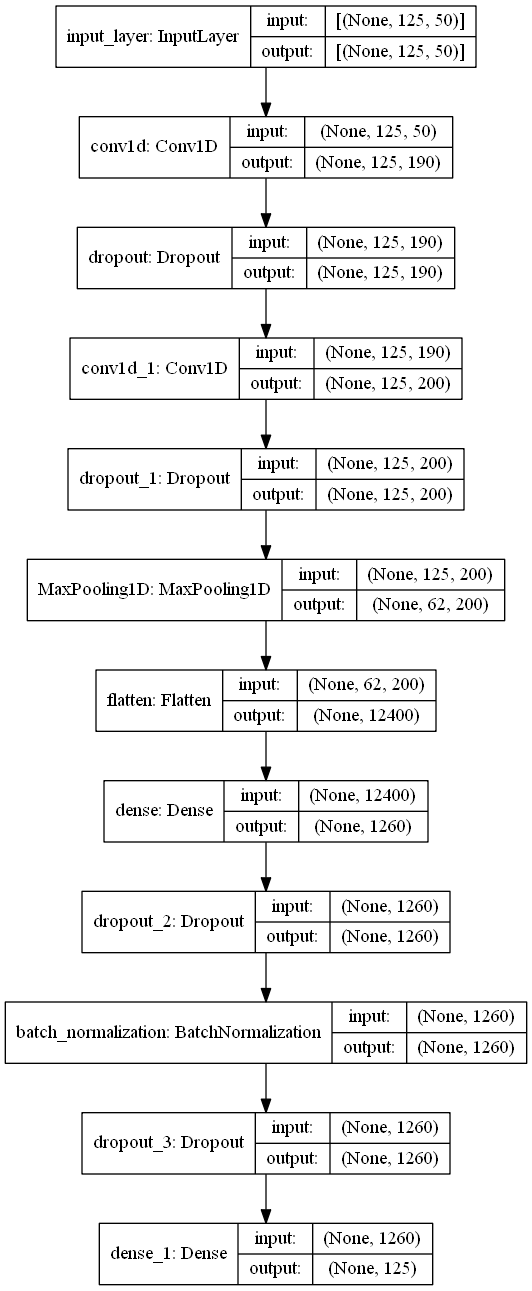

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(reconstructed_model, to_file='Images/1D_CNN.png',show_shapes=True, show_layer_names=True)

## Visualize statistics

In [ ]:
pruned_trials = study2.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study2.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study2.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print('')
print('Best value')
print(study2.best_value)
print('Best parameters')
print(study2.best_params)

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  1
  Number of complete trials:  99

Best value
4.0188212394714355
Best parameters
{'window_size': 125, 'n_layers_conv': 2, 'activ_fun_conv': 'tanh', 'filters_layer0': 190, 'kernel_size': 4, 'filters_layer1': 200, 'n_layers_nn': 1, 'activ_fun_nn': 'linear', 'n_units_l0': 1260}


In [ ]:
optuna.visualization.plot_optimization_history(study2)

In [ ]:
optuna.visualization.plot_slice(study2)  # best plot

## Model performance

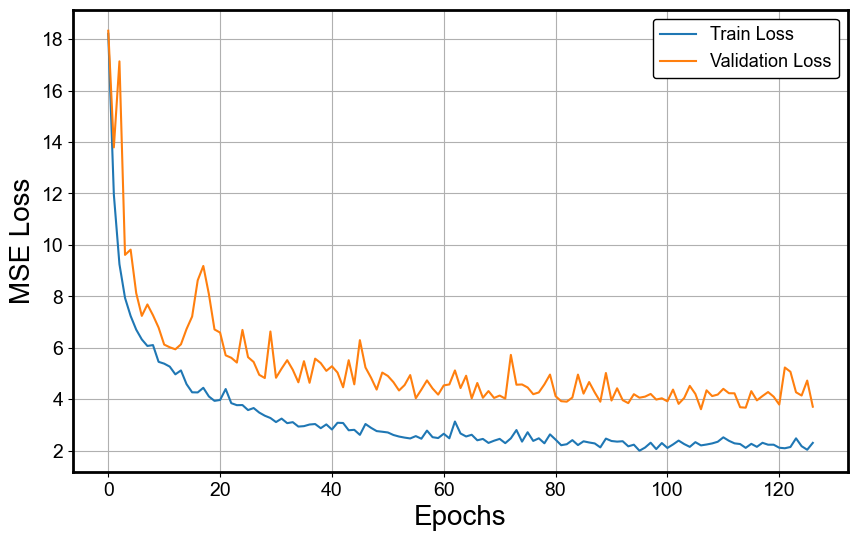

In [ ]:
def plot_learning_curve(model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,6))
        
    ax.plot(model.history['loss'], label = 'Train Loss')
    ax.plot(model.history['val_loss'], label = 'Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.show()
    
plot_learning_curve(best_model_history)

In [ ]:
X_train_re, y_train_re, X_test_re, y_test_re = create_scaled_dataset_reshaped(X, y,window_size=125)

In [ ]:
reconstructed_model.evaluate(X_test_re,y_test_re)

8/8 [==============================] - 0s 5ms/step - loss: 4.0188


4.0188212394714355

In [ ]:
yhat = reconstructed_model.predict(X_test_re)
yhat = yhat.reshape(-1, 1)
yhat.shape

(30000, 1)

In [ ]:
y_test_2 = tf.reshape(y_test_re, (y_test_re.shape[0]*y_test_re.shape[1],1))
y_test_2.shape

TensorShape([30000, 1])

(169601.05, 202599.95)

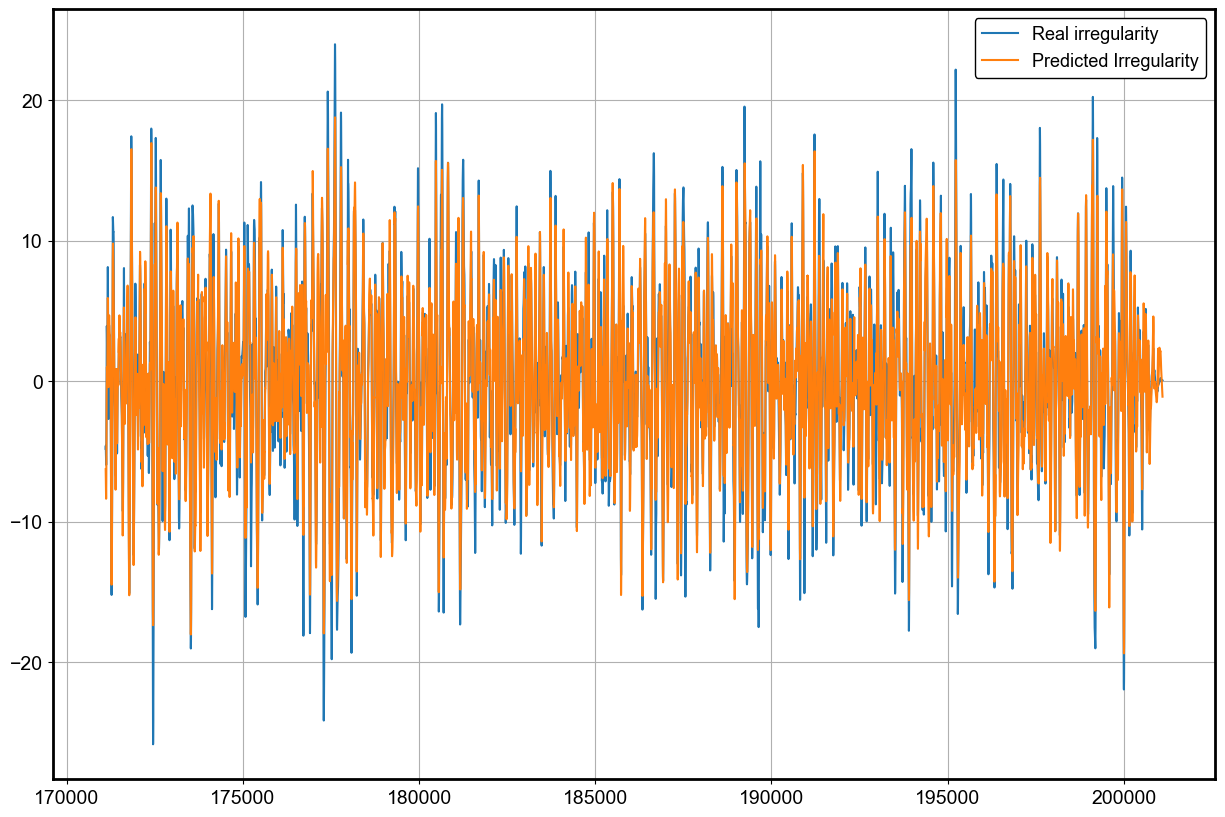

In [ ]:
plt.plot(y_test.index,y_test_2, label='Real irregularity')
plt.plot(y_test.index, yhat, label='Predicted Irregularity')
plt.legend()

plt.xlim()

Text(0.5, 0, 'Distance (m)')

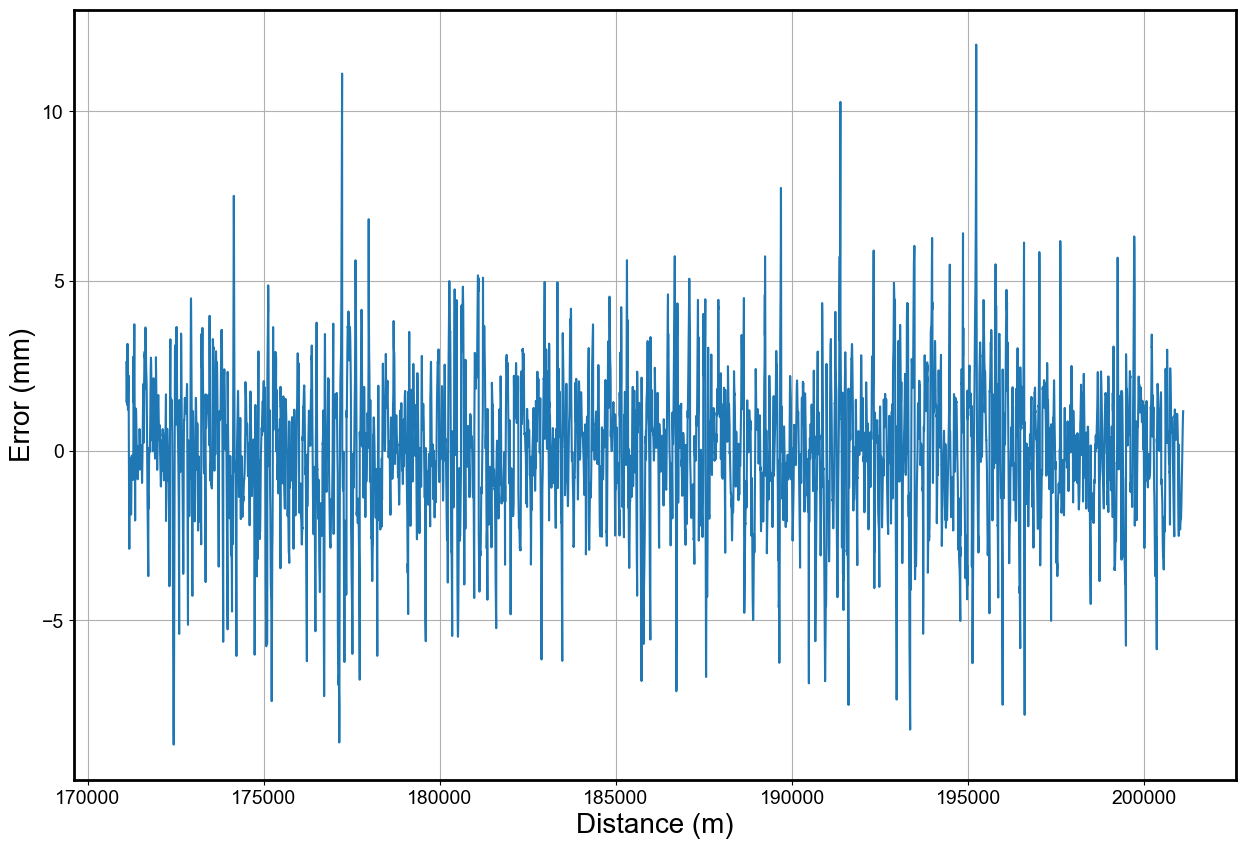

In [ ]:
error = y_test_2 - yhat
plt.plot(y_test.index,error)
plt.ylabel('Error (mm)')
plt.xlabel('Distance (m)')

In [ ]:
metrics(yhat,y_test_2)

MSE:4.018821015202303 
MAE:1.5194582559029446 
R2:0.8880768042072584
